# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [28]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from time import gmtime,strftime
from scipy.stats import linregress
from pprint import pprint
import os

# Import API key
from config import weather_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output Date (for csv and images)
output_date = strftime("%m%d%Y",gmtime())
output_path = "output/%s/" % output_date

# API variables
query_url = "http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=" % weather_key

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Plot Generator Functions

In [29]:
def buildLatPlot(y, ylabel, df, grid=False, linregress=False, save=False):
    x_val = df["Lat"]
    y_val = df[y]
    
    # X limits
    x_min = x_val.min()
    x_max = x_val.max()
    x_lim = getLimits(x_min, x_max, 10)
    
    # Y limits
    y_min = y_val.min()
    y_max = y_val.max()
    y_lim = getLimits(y_min, y_max, 5)
    
    # Create title
    date = strftime("%m/%d/%Y",gmtime())
    title = "City Latitude vs. {0}: {1}".format(ylabel,date)
    
    # Create and show plot
    lat_plt = df.plot(kind="scatter", x="Lat", y=y, grid=grid,
                       edgecolor="black", facecolor="blue", alpha=.75,
                       xlim=x_lim, ylim=y_lim, title=title)
    xlabel = "Latitude"
    lat_plt.set_xlabel(xlabel)
    lat_plt.set_ylabel(ylabel)
    lat_plt.axvline(0, color='black', linestyle='-', linewidth='3')
    
    # If desired, add the linear regression line and equation to the plot
    if linregress is True:
        x = {
            "values": x_val,
            "min": x_min,
            "max": x_max
        }
        y = {
            "values": y_val,
            "min": y_min,
            "max": y_max
        }
        addLinregress(x,y,lat_plt)
    
    # If desired, save the plot as a png in the output folder
    if save is True:
        output_ylabel = " ".join(ylabel.split()[:-1])
        #check if today already has a directory
        if os.path.isdir(output_path) is False:
            createNewDir(output_path)
        lat_plt.figure.savefig("{0}{1}-{2}.png".format(output_path,xlabel,output_ylabel))

In [30]:
# Gets the limits of the chart based on the minimum and maximum values
# The landmark value is what to round to so no plot points are chopped off when the plot renders
def getLimits(in_min, in_max, landmark):
    # get minimum
    if in_min <= 0:
        out_min = in_min-(landmark-(abs(in_min)%landmark))
    else:
        out_min = in_min-(in_min%landmark)
    # get maximum
    if in_max >= 0:
        out_max = in_max+(landmark-(in_max%landmark))
    else:
        out_max = in_max+(abs(in_max)%landmark)
    return (out_min,out_max)

In [59]:
# Add linear regression line and equation to the plot
def addLinregress(x,y,lat_plt):
    # get linear regression values and plot the line
    slope, intercept, rvalue, pvalue, stderr = linregress(x["values"], y["values"])
    lin_val = slope*x["values"] + intercept
    lat_plt.plot(x["values"],lin_val,"-",color="red")
    
    # create the equation string
    lin_eq = "y = {0}x + {1}".format(round(slope,2),round(intercept,2))
    
    # create coordinates for linear regression equation based on slope to try and minimize collision the data
    lin_x_buffer = (abs(.05*(x["min"]+x["max"])))
    lin_x = x["min"]+lin_x_buffer
    
    lin_y_buffer = (abs(.1*(y["min"]+y["max"])))
    if slope > -1:
        lin_y = y["max"]-lin_y_buffer
    else:
        lin_y = y["min"]+lin_y_buffer
    
    # add to existing plot
    lat_plt.annotate(lin_eq,(lin_x, lin_y),fontsize=15,color="red")
    
    # print r value
    print(f"The r-value is: {rvalue}")

In [32]:
# Create a date-specific folder
def createNewDir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Failed to create directory for %s. Saving to output/" % path)
        output_path = "output/"
    else:
        print ("Created directory for %s" % path)

## Generate Cities List

In [5]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

608

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
# Print title and divider
print_title = "Beginning Data Retrieval"
print(print_title)
print(len(print_title)*"-")

# Request weather data from every city in list
# Instantiate counters and city list
record = 1
rec_set = 1
city_list = []

# Loop through the cities and store the api response
for city in cities:
    response = requests.get(query_url + city).json()
    # if the response doesn't have a name, skip adding it to the city list and do not increment
    try:
        print(f"Processing Record {record} of Set {rec_set} | {response['name']}")
    except KeyError:
        print("City not found. Skipping...")
    else:
        city_list.append(response)
        if record == 50:
            record = 1
            rec_set += 1
        else:
            record += 1
    # Lastly, wait a second before making another call
    finally:
        time.sleep(1)

Beginning Data Retrieval
------------------------
Processing Record 1 of Set 1 | Punta Arenas
Processing Record 2 of Set 1 | Cape Town
Processing Record 3 of Set 1 | Kapaa
Processing Record 4 of Set 1 | Manggar
Processing Record 5 of Set 1 | Rikitea
Processing Record 6 of Set 1 | George Town
City not found. Skipping...
Processing Record 7 of Set 1 | Kahului
Processing Record 8 of Set 1 | Abu Dhabi
Processing Record 9 of Set 1 | Albany
Processing Record 10 of Set 1 | Vorontsovka
Processing Record 11 of Set 1 | Bluff
Processing Record 12 of Set 1 | Berlevåg
Processing Record 13 of Set 1 | Yellowknife
Processing Record 14 of Set 1 | Tvøroyri
Processing Record 15 of Set 1 | Pochutla
Processing Record 16 of Set 1 | Springbok
Processing Record 17 of Set 1 | Barrow
Processing Record 18 of Set 1 | Carnarvon
Processing Record 19 of Set 1 | Rocha
Processing Record 20 of Set 1 | Nago
City not found. Skipping...
Processing Record 21 of Set 1 | Melfort
Processing Record 22 of Set 1 | Ushuaia
City n

Processing Record 35 of Set 4 | Angoche
City not found. Skipping...
Processing Record 36 of Set 4 | Shimoda
Processing Record 37 of Set 4 | Karlstad
Processing Record 38 of Set 4 | Ligayan
Processing Record 39 of Set 4 | Yulara
Processing Record 40 of Set 4 | Buena Vista
Processing Record 41 of Set 4 | Alofi
Processing Record 42 of Set 4 | Kichera
Processing Record 43 of Set 4 | Caravelas
Processing Record 44 of Set 4 | Orchard Homes
Processing Record 45 of Set 4 | Būlaevo
Processing Record 46 of Set 4 | Seoul
Processing Record 47 of Set 4 | Launceston
Processing Record 48 of Set 4 | Avera
Processing Record 49 of Set 4 | Qaanaaq
Processing Record 50 of Set 4 | Mbanza-Ngungu
Processing Record 1 of Set 5 | Ponta do Sol
Processing Record 2 of Set 5 | Manitouwadge
Processing Record 3 of Set 5 | Necochea
Processing Record 4 of Set 5 | Shakawe
Processing Record 5 of Set 5 | Cidreira
Processing Record 6 of Set 5 | Coos Bay
Processing Record 7 of Set 5 | Gornyy
Processing Record 8 of Set 5 | L

Processing Record 23 of Set 8 | Wiang Sa
Processing Record 24 of Set 8 | Tombouctou
Processing Record 25 of Set 8 | Acajutla
Processing Record 26 of Set 8 | Kropotkin
City not found. Skipping...
Processing Record 27 of Set 8 | Saint-Pierre
Processing Record 28 of Set 8 | Fukuechō
Processing Record 29 of Set 8 | Constitución
Processing Record 30 of Set 8 | Valparaíso
Processing Record 31 of Set 8 | Te Anau
Processing Record 32 of Set 8 | Padang
Processing Record 33 of Set 8 | Luocheng
Processing Record 34 of Set 8 | Hobyo
Processing Record 35 of Set 8 | Sawai Madhopur
Processing Record 36 of Set 8 | Port Lincoln
Processing Record 37 of Set 8 | Canutama
Processing Record 38 of Set 8 | Dhārchula
Processing Record 39 of Set 8 | Rawson
Processing Record 40 of Set 8 | Maţāy
Processing Record 41 of Set 8 | Luwuk
Processing Record 42 of Set 8 | Guerrero Negro
Processing Record 43 of Set 8 | Kruisfontein
Processing Record 44 of Set 8 | Poum
Processing Record 45 of Set 8 | Kalmunai
Processing Re

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [17]:
# Create empty dictionary to add api data to
cities_df = {}

# Add City, Lat, Long, Max Temp, Humidity, Cloudiness, Wind Speed, Country, and Date
# Create empty lists for each soon-to-be column
cities_df["City"], cities_df["Lat"], cities_df["Lng"], cities_df["Max Temp"], cities_df["Humidity"], cities_df["Cloudiness"], cities_df["Wind Speed"], cities_df["Country"], cities_df["Date"] = ([] for x in range(9))
for i in range(len(city_list)):
    cities_df["City"].append(city_list[i]["name"])
    cities_df["Lat"].append(city_list[i]["coord"]["lat"])
    cities_df["Lng"].append(city_list[i]["coord"]["lon"])
    cities_df["Max Temp"].append(city_list[i]["main"]["temp_max"])
    cities_df["Humidity"].append(city_list[i]["main"]["humidity"])
    cities_df["Cloudiness"].append(city_list[i]["clouds"]["all"])
    cities_df["Wind Speed"].append(city_list[i]["wind"]["speed"])
    cities_df["Country"].append(city_list[i]["sys"]["country"])
    cities_df["Date"].append(city_list[i]["dt"])
cities_df = pd.DataFrame(cities_df)
if os.path.isdir(output_path) is False:
    createNewDir(output_path)
cities_df.to_csv("%scities.csv" % output_path)
cities_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Punta Arenas,-53.15,-70.92,60.80,72,0,4.70,CL,1609518295
1,Cape Town,-33.93,18.42,71.60,43,0,29.97,ZA,1609518031
2,Kapaa,22.08,-159.32,75.20,73,40,21.92,US,1609518297
3,Manggar,-2.88,108.27,79.61,83,97,4.12,ID,1609518298
4,Rikitea,-23.12,-134.97,77.43,68,14,11.10,PF,1609518299


In [18]:
cities_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,551.000000,551.000000,551.000000,551.000000,551.00000,551.000000,5.510000e+02
mean,20.135009,20.933485,50.070962,72.965517,55.07804,8.102740,1.609519e+09
std,34.095655,89.274246,33.699158,19.860072,39.77559,5.624859,2.053785e+02
min,-54.800000,-175.200000,-37.160000,11.000000,0.00000,0.340000,1.609518e+09
25%,-8.850000,-55.080000,32.000000,64.000000,12.00000,4.090000,1.609518e+09
50%,25.620000,25.680000,60.010000,78.000000,72.00000,6.930000,1.609519e+09
75%,49.120000,99.855000,77.395000,87.000000,93.00000,10.815000,1.609519e+09
max,78.220000,179.320000,103.150000,100.000000,100.00000,35.790000,1.609519e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
clean_city_df = cities_df.loc[cities_df["Humidity"] <= 100, :]
clean_city_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Punta Arenas,-53.15,-70.92,60.80,72,0,4.70,CL,1609518295
1,Cape Town,-33.93,18.42,71.60,43,0,29.97,ZA,1609518031
2,Kapaa,22.08,-159.32,75.20,73,40,21.92,US,1609518297
3,Manggar,-2.88,108.27,79.61,83,97,4.12,ID,1609518298
4,Rikitea,-23.12,-134.97,77.43,68,14,11.10,PF,1609518299


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

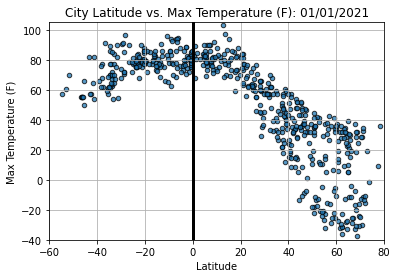

In [20]:
buildLatPlot("Max Temp", "Max Temperature (F)", clean_city_df, grid=True, save=True)

##### Jan. 1st, 2021 Analysis:
This plot depicts the correlation between a city's maximum temperature and its latitude. Overall, the points are relatively tightly clustered with about 20 degrees Fahrenheit of separation between all cities at a specific latitude. This holds true from -60 degrees to about 25 degrees latitude where the variance begins to increase. The trend still holds true -- the closer to the equator, the greater the maximum temperature -- but above 25 degrees latitude, the correlation weakens slightly.

## Latitude vs. Humidity Plot

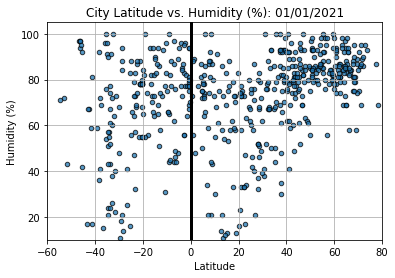

In [22]:
buildLatPlot("Humidity", "Humidity (%)", clean_city_df, grid=True, save=True)

## Latitude vs. Cloudiness Plot

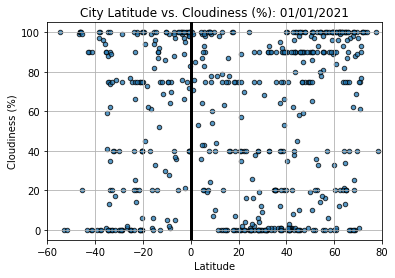

In [23]:
buildLatPlot("Cloudiness", "Cloudiness (%)", clean_city_df, grid=True, save=True)

## Latitude vs. Wind Speed Plot

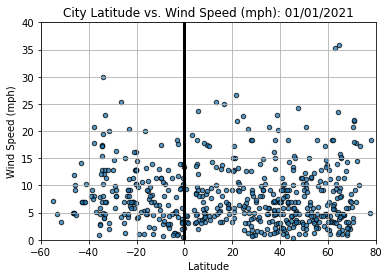

In [24]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", clean_city_df, grid=True, save=True)

## Linear Regression

In [25]:
# Collect hemisphere-specific data
# Both include cities on the Equator
north_hemi_df = clean_city_df.loc[clean_city_df["Lat"] >= 0, :]
south_hemi_df = clean_city_df.loc[clean_city_df["Lat"] <= 0, :]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.8298430376522303


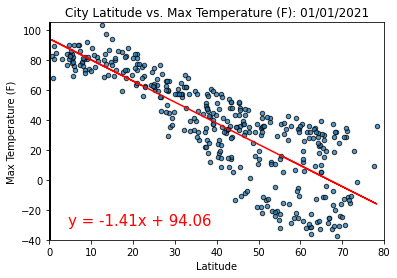

In [60]:
buildLatPlot("Max Temp", "Max Temperature (F)", north_hemi_df, linregress=True)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.531112885504311


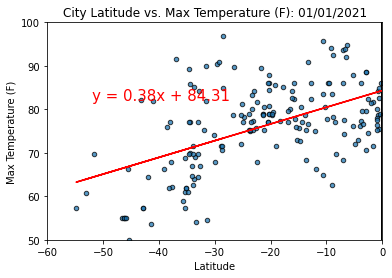

In [61]:
buildLatPlot("Max Temp", "Max Temperature (F)", south_hemi_df, linregress=True)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.44600539555507035


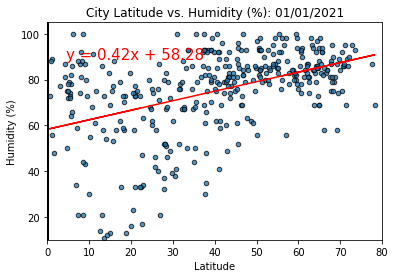

In [62]:
buildLatPlot("Humidity", "Humidity (%)", north_hemi_df, linregress=True)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.2371849728492959


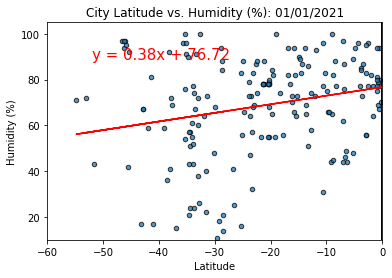

In [63]:
buildLatPlot("Humidity", "Humidity (%)", south_hemi_df, linregress=True)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.17361043370163562


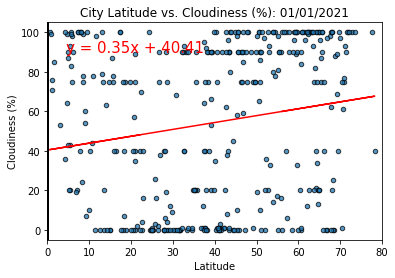

In [64]:
buildLatPlot("Cloudiness", "Cloudiness (%)", north_hemi_df, linregress=True)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.2158576136388966


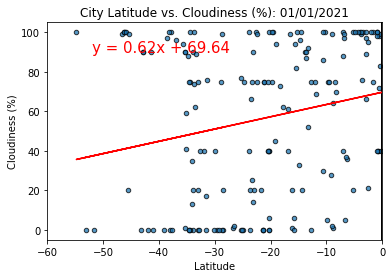

In [65]:
buildLatPlot("Cloudiness", "Cloudiness (%)", south_hemi_df, linregress=True)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.007909621582365786


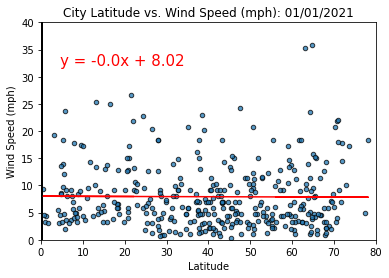

In [66]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", north_hemi_df, linregress=True)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.16369409027328108


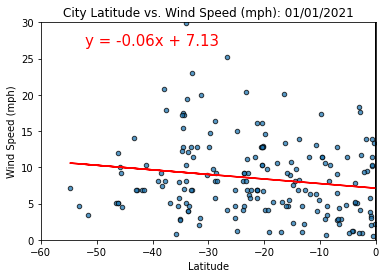

In [67]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", south_hemi_df, linregress=True)